In [19]:
from src.utils import load_latest_h5
from src.features import create_dataset, scale_data, inverse_y_array
from src.entities import FeatureParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


In [20]:
input_path = '../src/models/saved_models/'
model = load_latest_h5(input_path)


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            20600     
                                                                 
 layer_normalization (Layer  (None, 10, 50)            20        
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 layer_normalization_1 (Lay  (None, 50)                100       
 erNormalization)                                                
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 40971 (160.04 KB)
Trainable params: 40971 

In [22]:
feature_params = FeatureParams(
    categorical_features=['Store'],
    numerical_features=[
                    "Weekly_Sales",
                    "Holiday_Flag",
                    "Temperature",
                    "Fuel_Price",
                    "CPI",
                    "Unemployment"
                ],
    target_col='Weekly_Sales',
)

In [23]:
input_data_path = "../data/raw/train.csv"
df = pd.read_csv(input_data_path)
sales_data_normalized, scaler = scale_data(df, feature_params)
time_steps = 10
X, y, shape = create_dataset(sales_data_normalized, time_steps)
train_size = int(0.7 * len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)
y_predict = model.predict(X_test)


61/61 [==============================] - 0s 1ms/step


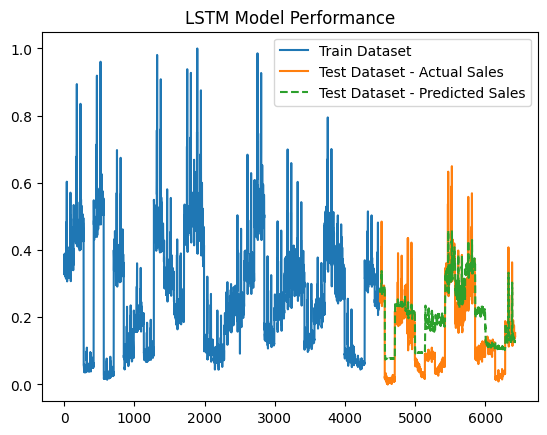

In [24]:
data_y = pd.DataFrame({'true':y_train.squeeze().tolist() + y_test.squeeze().tolist(),
              'predict':y_train.squeeze().tolist() + y_predict.squeeze().tolist(),})

train_index = len(y_train.squeeze().tolist())
test_index = len(y_test.squeeze().tolist())

train, test = data_y.iloc[:train_index], data_y.iloc[train_index:]

plt.plot(train.index, train['true'], label='Train Dataset')
plt.plot(test.index,  test['true'], label='Test Dataset - Actual Sales')
# plt.plot(data_y.index,  data_y['true'], label='Actual')
plt.plot(test.index,  test['predict'], label='Test Dataset - Predicted Sales', linestyle='dashed')
plt.title('LSTM Model Performance')
plt.legend()
plt.show()

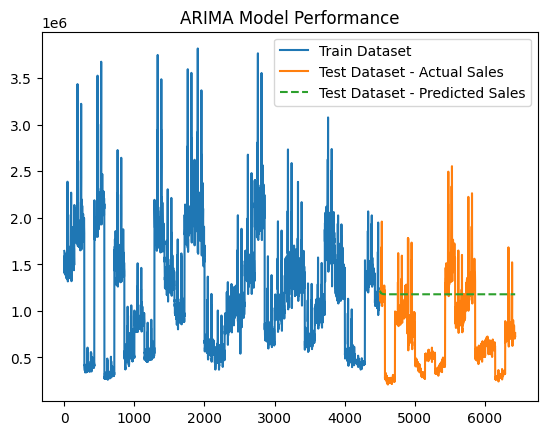

RMSE: 583102.0431011204


In [56]:
label = feature_params.target_col

df_new = pd.DataFrame(df[label])

train_size = int(len(df) * 0.7)
train, test = df_new.iloc[:train_size], df_new.iloc[train_size:]

order = (1,0,0)
s_order = (0, 0, 2, 12)  
arima_model = ARIMA(train,order=order, seasonal_order=s_order)
fit_model = arima_model.fit()


predictions = fit_model.forecast(steps=len(test))

plt.plot(train.index, train[label], label='Train Dataset')
plt.plot(test.index,  test[label], label='Test Dataset - Actual Sales')
plt.plot(test.index,  predictions, label='Test Dataset - Predicted Sales', linestyle='dashed')
plt.title('ARIMA Model Performance')
plt.legend()
plt.show()

# # 计算 RMSE（均方根误差）
rmse = np.sqrt(mean_squared_error(test[label], predictions))
print(f'RMSE: {rmse}')